In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, SimpleImputer
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


In [10]:
df = pd.read_csv("only2123.csv")
print(f"Loaded dataset: {df.shape[0]} rows, {df.shape[1]} columns")

Loaded dataset: 862986 rows, 17 columns


In [11]:
missing_pct = df.isna().mean() * 100
print("\nMissingness (% per column):")
print(missing_pct.sort_values(ascending=False))


Missingness (% per column):
income                  72.804194
smoke_status            62.649916
poor_health_days        46.967042
employment              33.082692
bmi                      9.932027
physical_health_days     4.142130
mental_health_days       3.602492
marital                  1.028058
coronary_hd              0.911602
heart_attack             0.538363
education                0.518896
hypertension             0.389230
general_health           0.267096
exercise_any             0.233376
diabetes                 0.000000
sex                      0.000000
year                     0.000000
dtype: float64


In [12]:
df_clean = df.copy()
dropped_cols = []
added_indicators = []

for col in df.columns:
    miss_rate = missing_pct[col]
    if miss_rate == 0:
        continue

    # >40% → Drop feature
    if miss_rate > 40:
        print(f" Dropping {col} ({miss_rate:.1f}% missing)")
        df_clean.drop(columns=[col], inplace=True)
        dropped_cols.append(col)
        continue

    # 20–40% → Add missing indicator + simple imputation
    elif 20 < miss_rate <= 40:
        print(f" Adding indicator + simple imputation for {col} ({miss_rate:.1f}%)")
        df_clean[f"{col}_missing"] = df_clean[col].isna().astype(int)
        added_indicators.append(f"{col}_missing")
        if df_clean[col].dtype == 'object':
            imp = SimpleImputer(strategy='most_frequent')
        else:
            imp = SimpleImputer(strategy='median')
        df_clean[col] = imp.fit_transform(df_clean[[col]])

    # 5–20% → KNN or MICE imputation
    elif 5 < miss_rate <= 20:
        print(f" KNN/MICE imputation for {col} ({miss_rate:.1f}%)")
        if df_clean[col].dtype == 'object':
            imp = SimpleImputer(strategy='most_frequent')
            df_clean[col] = imp.fit_transform(df_clean[[col]])
        else:
            imp = IterativeImputer(random_state=42)
            df_clean[[col]] = imp.fit_transform(df_clean[[col]])

    # <5% → Simple imputation or drop rows
    elif 0 < miss_rate <= 5:
        print(f" Simple imputation for {col} ({miss_rate:.1f}%)")
        if df_clean[col].dtype == 'object':
            imp = SimpleImputer(strategy='most_frequent')
        else:
            imp = SimpleImputer(strategy='median')
        df_clean[col] = imp.fit_transform(df_clean[[col]])





print(f"\nDropped columns: {dropped_cols}")
print(f"Added indicators: {added_indicators}")

 Simple imputation for education (0.5%)
 Dropping income (72.8% missing)
 Adding indicator + simple imputation for employment (33.1%)
 Simple imputation for marital (1.0%)
 Simple imputation for exercise_any (0.2%)
 Dropping smoke_status (62.6% missing)
 KNN/MICE imputation for bmi (9.9%)
 Simple imputation for general_health (0.3%)
 Simple imputation for physical_health_days (4.1%)
 Simple imputation for mental_health_days (3.6%)
 Dropping poor_health_days (47.0% missing)
 Simple imputation for hypertension (0.4%)
 Simple imputation for heart_attack (0.5%)
 Simple imputation for coronary_hd (0.9%)

Dropped columns: ['income', 'smoke_status', 'poor_health_days']
Added indicators: ['employment_missing']


In [13]:
cat_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
print(f"\nEncoding {len(cat_cols)} categorical columns...")

encoder = LabelEncoder()
for col in cat_cols:
    df_clean[col] = encoder.fit_transform(df_clean[col].astype(str))


Encoding 0 categorical columns...


In [14]:
target_col = 'diabetes'
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

if 'year' in X.columns:
    X.drop(columns=['year'], inplace=True)
    print(" Dropped 'year' column.")

 Dropped 'year' column.


In [15]:
sm = SMOTE(random_state=42, sampling_strategy=0.3)
X_res, y_res = sm.fit_resample(X_train, y_train)
model = LGBMClassifier(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=10,
    num_leaves=64,
    min_child_samples=30,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.1,
    reg_lambda=0.1,
    class_weight={0:1, 1:3},  # increase weight for diabetic class
    random_state=42
)
model.fit(X_res, y_res)

[LightGBM] [Info] Number of positive: 174011, number of negative: 580038
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2926
[LightGBM] [Info] Number of data points in the train set: 754049, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473684 -> initscore=-0.105363
[LightGBM] [Info] Start training from score -0.105363


,boosting_type,'gbdt'
,num_leaves,64
,max_depth,10
,learning_rate,0.03
,n_estimators,800
,subsample_for_bin,200000
,objective,None
,class_weight,"{0: 1, 1: 3}"
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,30



Classification Report (Tuned Model):
              precision    recall  f1-score   support

         0.0      0.920     0.785     0.847    145010
         1.0      0.362     0.642     0.463     27588

    accuracy                          0.762    172598
   macro avg      0.641     0.714     0.655    172598
weighted avg      0.831     0.762     0.786    172598

ROC-AUC: 0.7969


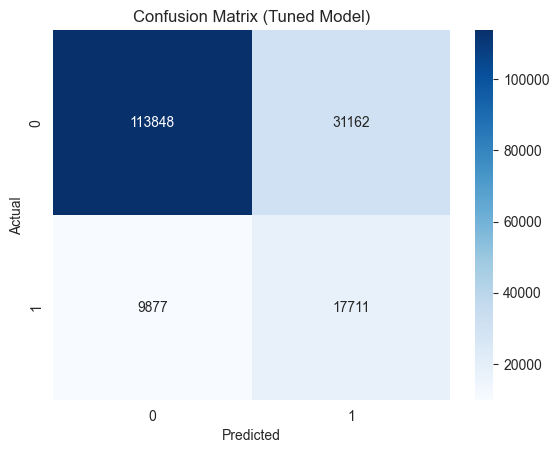

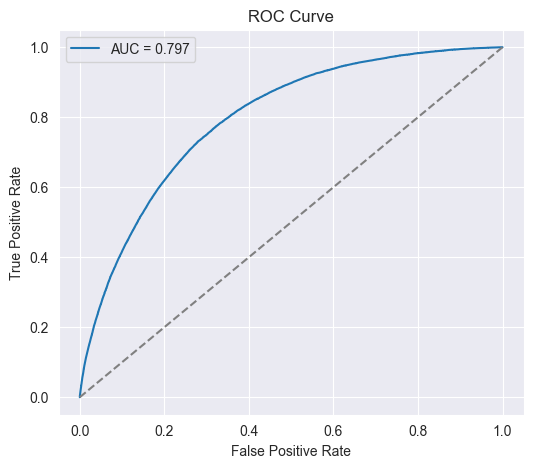

ValueError: Length of values (14) does not match length of index (13)

In [17]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("\nClassification Report (Tuned Model):")
print(classification_report(y_test, y_pred, digits=3))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Tuned Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.legend()
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()
